# Importing Libraries

In [1]:
import os
import re
import unicodedata
from time import gmtime, strftime
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import time
import requests
from lxml import html
from tqdm import tqdm
from bs4 import BeautifulSoup as bs

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize

from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
ps = SnowballStemmer("english")

from gensim import corpora
from wordcloud import WordCloud
from gensim.models import TfidfModel, LdaMulticore

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from textblob import TextBlob
from collections import Counter
import pandas_datareader.data as web

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Scraping

In [2]:
stock_tickers = ["AMZN", "AAPL", "NVDA", "META"]
stock_tickers = ["NVDA"]

In [3]:
# Function to convert stock ticker into CIK for SEC
def TickerToCik(tickers):
    
    _url = 'http://www.sec.gov/cgi-bin/browse-edgar?CIK={}&Find=Search&owner=exclude&action=getcompany'
    cik_re = re.compile(r'.*CIK=(\d{10}).*')  # checking for CIK = 10 digit number

    ticker_to_cik = {}
    headers = {'User-Agent': 'Quantamental shrajal@quantamental.com'}
    
    for ticker in tqdm(tickers, desc='Mapping Tickers to CIK', unit=' Mappings'):
        try:
            response = requests.get(_url.format(ticker), headers=headers)
            response.raise_for_status()  # Raises an error for bad responses
            results = cik_re.findall(response.text)
            
            if results:
                ticker_to_cik[str(ticker).lower()] = str(results[0])
        
        except requests.exceptions.RequestException as e:
            print(f"An error occurred for ticker {ticker}: {e}")
    
    return ticker_to_cik

In [4]:
ciks = TickerToCik(stock_tickers)
ciks

Mapping Tickers to CIK: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53 Mappings/s]


{'nvda': '0001045810'}

In [5]:
tick_cik_df = pd.DataFrame.from_dict(data=ciks, orient='index')
tick_cik_df.reset_index(inplace=True)
tick_cik_df.columns = ["ticker", "cik"]
tick_cik_df['cik'] = tick_cik_df['cik'].str.lower()
tick_cik_df

,ticker,cik
0,nvda,0001045810


# Storing the Data

In [6]:
path_10k = 'C:/Users/shraj/Downloads/'

In [7]:
def makefolder(path):
    
    try:
        os.mkdir(path + '10Ks')
    except:
        print("Folder/Directory for 10K already created")
        
    return path_10k + '10Ks'

path_10k = makefolder(path_10k)

Folder/Directory for 10K already created


In [8]:
def Scrape10K(base_url, filing_url, doc_url, cik):
    headers = {'User-Agent': 'Quantamental shrajal@quantamental.com'}
    
    # Check if we've already scraped this CIK
    try:
        os.mkdir(cik)
    except OSError:
        print("The CIK has already been scraped", cik)
        return
    
    # Setting current directory for that CIK
    try:
        os.chdir(cik)
    except Exception as e:
        print(f"Error changing directory to {cik}: {e}")
        return

    print('Scraping CIK', cik)
    
    # Request list of 10-K filings
    try:
        base_res = requests.get(base_url % cik, headers=headers)
        base_res.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching base URL for CIK {cik}: {e}")
        os.chdir('..')
        return

    # Parse the response HTML using BeautifulSoup
    base_soup = bs(base_res.text, "lxml")

    # Extract all tables from the response
    base_html_tables = base_soup.find_all('table')

    # Check that the table we're looking for exists
    if len(base_html_tables) < 3:
        print(f"No appropriate table found for CIK {cik}.")
        os.chdir('..')
        return
    
    # Parse the Filings table
    try:
        fil_table = pd.read_html(str(base_html_tables[2]), header=0)[0]
    except ValueError as e:
        print(f"Error reading HTML table for CIK {cik}: {e}")
        os.chdir('..')
        return
    
    fil_table['Filings'] = fil_table['Filings'].astype(str)

    # Get only 10-K and 10-K405 document filings
    fil_table = fil_table[(fil_table['Filings'] == '10-K') | (fil_table['Filings'] == '10-K405')]

    # If filings table doesn't have any 10-Ks or 10-K405s, exit
    if fil_table.empty:
        print(f"No 10-K or 10-K405 filings found for CIK {cik}.")
        os.chdir('..')
        return
    
    # Get accession number for each 10-K and 10-K405 filing
    fil_table['Acc_No'] = fil_table['Description'].str.extract(r'Acc-no:\s+(\S+)')
   
    # Iterate through each filing and scrape the corresponding document...
    for index, row in fil_table.iterrows():
        acc_no = str(row['Acc_No'])
        try:
            docs_page_html = bs(requests.get(filing_url % (cik, acc_no), headers=headers).text, 'lxml')
        except requests.exceptions.RequestException as e:
            print(f"Error fetching filing URL for CIK {cik} and accession {acc_no}: {e}")
            continue
        
        docs_tables = docs_page_html.find_all('table')
        if not docs_tables:
            continue
        
        try:
            docs_df = pd.read_html(str(docs_tables[0]), header=0)[0]
        except ValueError:
            continue
        
        docs_df['Type'] = docs_df['Type'].astype(str)
        
        # Get the 10-K for the filing
        docs_df = docs_df[(docs_df['Type'] == '10-K') | (docs_df['Type'] == '10-K405')]
        
        if docs_df.empty:
            continue
        
        docname = docs_df.iloc[0]['Document']
    
        if pd.notna(docname):
            try:
                file_url = str(doc_url % (cik, acc_no.replace('-', ''), docname)).split()[0]
                file = requests.get(file_url, headers=headers)
                file.raise_for_status()
            except requests.exceptions.RequestException as e:
                print(f"Error fetching document for CIK {cik} and accession {acc_no}: {e}")
                continue

            # Save text as HTML
            date = str(row['Filing Date'])
            filename = f"{cik}_{date}.html"
            try:
                with open(filename, 'w') as html_file:
                    html_file.write(file.text)
            except IOError as e:
                print(f"Error writing file {filename} for CIK {cik}: {e}")

        time.sleep(1)  # Delay to avoid hitting rate limits

    # Move back to the main 10-K directory
    os.chdir('..')
    
    return

In [9]:
#Examples of the links that we will be scraping from
browse_url_base_10k = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=%s&type=10-K'
filing_url_base_10k = 'http://www.sec.gov/Archives/edgar/data/%s/%s-index.html'
doc_url_base_10k = 'http://www.sec.gov/Archives/edgar/data/%s/%s/%s'

In [10]:
os.chdir(path_10k)

# Iterate over CIKs and scrape 10-Ks
for cik in tqdm(tick_cik_df['cik']):
    Scrape10K(base_url=browse_url_base_10k, filing_url=filing_url_base_10k, doc_url=doc_url_base_10k, cik=cik)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.33it/s]

The CIK has already been scraped 0001045810


# Data Cleaning

In [11]:
# Remove all tags
def DelTags(file_soup):
    
    # Remove HTML tags 
    doc = file_soup.get_text()
    
    # Remove newline characters
    doc = doc.replace('\n', ' ')
    
    # Replace unicode characters with their "normal" representations
    doc = unicodedata.normalize('NFKD', doc)
    
    return doc

In [12]:
# Remove all tables (if their numeric character content is greater than 15)
def DelTables(file_soup):

    def GetDigitPercentage(tablestring):
        if len(tablestring) > 0.0:
            numbers = sum([char.isdigit() for char in tablestring])
            length = len(tablestring)
            
            return numbers / length
        else:
            return 1
    
    # Evaluates numerical character % for each table and removes the table if the percentage is > 15%
    [x.extract() for x in file_soup.find_all('table') if GetDigitPercentage(x.get_text()) > 0.15]
    
    return file_soup

In [13]:
def ConvertHTML(cik):
    
    # Look for files scraped for that CIK
    try: 
        os.chdir(cik)
    except FileNotFoundError:
        print("Directory not available CIK", cik)
        return
        
    print("Parsing CIK %s..." % cik)
    parsed = False # flag to tell if we've parsed anything
    
    # Make a new directory with all the .txt files called "textonly"
    try:
        os.mkdir('textonly')
    except OSError:
        pass
    
   # List of file in that directory
    file_list = [fname for fname in os.listdir() if not (fname.startswith('.') or os.path.isdir(fname))]
    
    # Iterate over scraped files and clean the html
    for filename in file_list:
            
        # Check if file has already been cleaned
        new_filename = filename.replace('.html', '.txt')
        text_file_list = os.listdir('textonly')
        if new_filename in text_file_list:
            continue
                
        # Clean file
        with open(filename, 'r', encoding='utf-8') as file:
            parsed = True
            soup = bs(file.read(), "lxml")
            soup = DelTables(soup)
            text = DelTags(soup)
            with open('textonly/' + new_filename, 'w', encoding='utf-8') as newfile:
                newfile.write(text)
    
    # If all files in the CIK directory have been parsed
    if parsed == False:
        print("Already parsed CIK", cik)
    
    os.chdir('..')
    return

In [14]:
os.chdir(path_10k)

# Iterate over CIKs and clean HTML filings
for cik in tqdm(tick_cik_df['cik']):
    ConvertHTML(cik)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.80it/s]

Parsing CIK 0001045810...
Already parsed CIK 0001045810


# Data Preprocessing

In [15]:
def lemmatize(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(w.lower()) for w in words]
    return lemmatized_words

def stem_words(words):
    stemmed = [ps.stem(w) for w in words]
    return stemmed

In [16]:
stop_words = set(stopwords.words('english'))
fin_stop_words = ("million", "including", "billion", "december", "january")
stop_words.update(fin_stop_words)

# removing stop words, numbers , removing punctuations and special characters and spaces
def remove_stopwords(words):
    filtered = []
    
    for word in words:
        
        # Remove punctuation and special characters
        cleaned_word = re.sub(r'[^\w\s]', '', word)
        
        # Check conditions for filtering words
        if (cleaned_word.lower() not in stop_words and     # Not in stop words
            not cleaned_word.isnumeric() and               # Not a number
            not re.search(r'^\s*[0-9]', cleaned_word) and  # Doesn't start with a number
            len(cleaned_word) > 3):                        # Longer than 3 characters
            filtered.append(cleaned_word)
    
    return filtered

In [17]:
wordcount = {}  # Dictionary to count sentences and tokens for each 10-K document
docs = {}  # Dictionary to save the tokens after preprocessing for each 10-K document
file_doc = {}  # Dictionary to save the sentences for each 10-K document

for cik in tqdm(tick_cik_df['cik'], desc="Processing CIKs"):
    
    # Setting directory to the .txt files folder
    cik_dir = os.path.join(path_10k, cik, "textonly")
    os.chdir(cik_dir)
    
    # Listing files in directory and sorting them
    files = sorted(os.listdir(), reverse=True)
    
    # Iterating over each 10-K file
    for file in files:
        
        with open(file, "r", encoding="utf-8") as f:
            text = f.read()
        
        # Sentence tokenization
        sents = sent_tokenize(text)
        file_doc = sents  # Save sentences for the first document
        
        # Word tokenization and preprocessing
        tokens = word_tokenize(text.lower())
        partial_lem = lemmatize(tokens)
        after_stopwords = remove_stopwords(partial_lem)
        
        # Save preprocessed tokens for each file
        docs[file] = after_stopwords
        
        # Count tokens and sentences
        counts = {
            "tokens": len(tokens),
            "sentences": len(sents)
        }
        wordcount[file] = counts

Processing CIKs: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.17s/it]


# Exploratory Data Analysis

In [18]:
dataset = [lemmatize(remove_stopwords(d.lower().split())) for d in file_doc]
dictionary = corpora.Dictionary(dataset)

corpus = [dictionary.doc2bow(file) for file in dataset]
tfidf= TfidfModel(corpus)

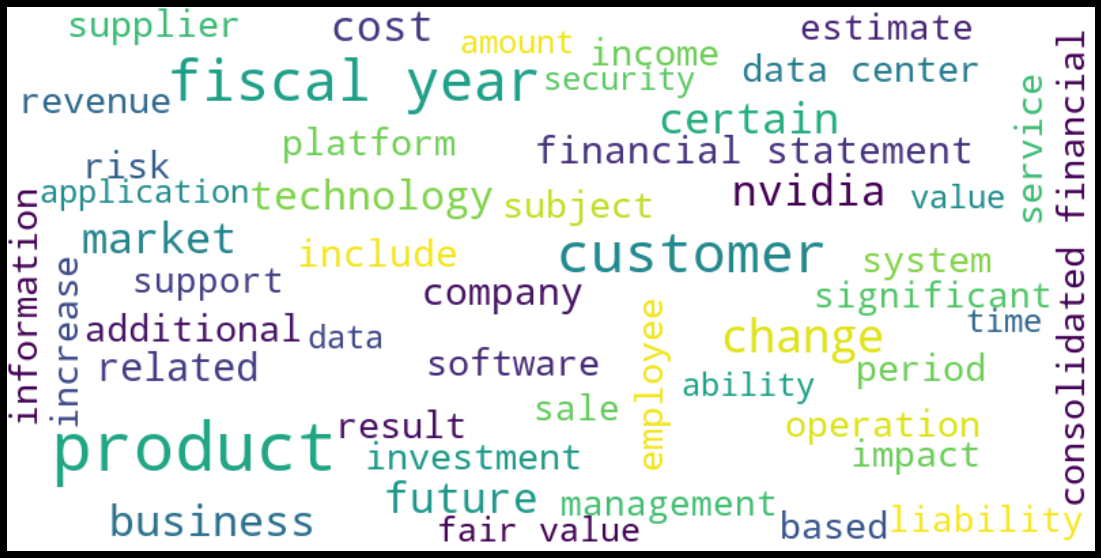

In [19]:
# Wordcloud for latest 10K
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", width=800, height=400).generate(" ".join(docs[list(docs.keys())[0]]))

plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

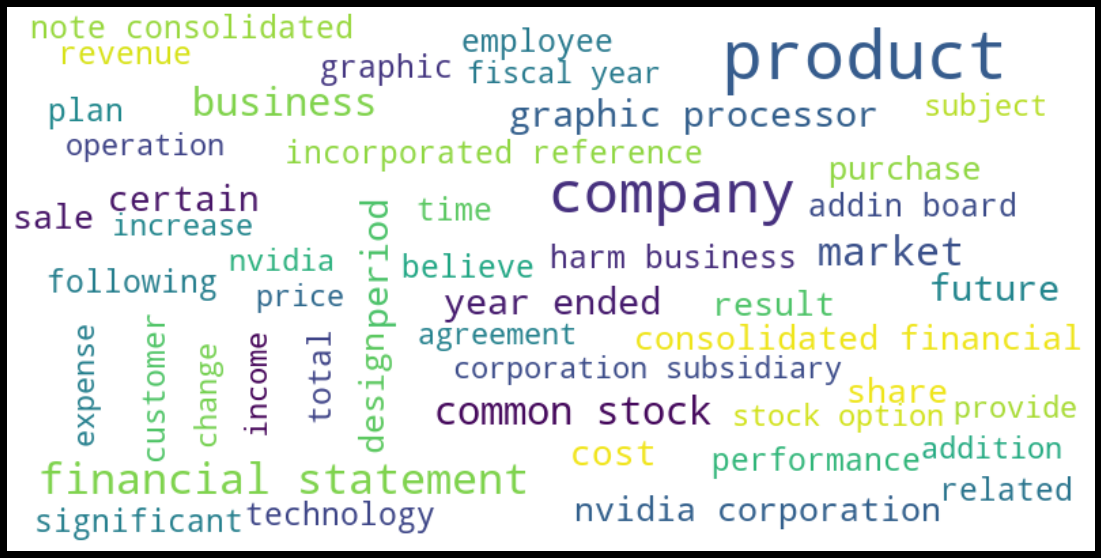

In [20]:
# Wordcloud for first 10K
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", width=800, height=400).generate(" ".join(docs[list(docs.keys())[-1]]))

plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# LDA Modeling

In [21]:
lda_model = LdaMulticore(corpus, num_topics = 5, id2word = dictionary, passes = 10, workers = 2)
lda_model.show_topics()

[(0,
  '0.020*"company" + 0.019*"graphic" + 0.014*"processor" + 0.013*"sale" + 0.011*"market" + 0.011*"product" + 0.009*"microsoft" + 0.008*"matter" + 0.008*"technology" + 0.008*"financial"'),
 (1,
  '0.016*"adjustment" + 0.014*"revenue" + 0.011*"agreement" + 0.011*"microsoft" + 0.009*"cost" + 0.009*"future" + 0.009*"price" + 0.008*"company" + 0.008*"reflect" + 0.007*"april"'),
 (2,
  '0.025*"share" + 0.024*"stock" + 0.021*"income" + 0.017*"note" + 0.017*"year" + 0.016*"financial" + 0.014*"common" + 0.013*"statement" + 0.013*"asset" + 0.013*"cash"'),
 (3,
  '0.018*"product" + 0.014*"board" + 0.014*"customer" + 0.012*"option" + 0.011*"director" + 0.011*"manufacturer" + 0.010*"period" + 0.010*"year" + 0.010*"plan" + 0.009*"addin"'),
 (4,
  '0.033*"product" + 0.025*"business" + 0.021*"could" + 0.014*"filed" + 0.012*"result" + 0.012*"market" + 0.011*"harm" + 0.010*"development" + 0.010*"graphic" + 0.009*"form"')]

In [22]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.231083  0.019012       1        1  27.310857
4     -0.100096  0.182388       2        1  22.516606
3     -0.034186 -0.043446       3        1  18.337878
0     -0.099620 -0.125177       4        1  18.260923
1      0.002820 -0.032777       5        1  13.573736, topic_info=             Term        Freq       Total Category  logprob  loglift
57          share  125.000000  125.000000  Default  30.0000  30.0000
221        income  101.000000  101.000000  Default  29.0000  29.0000
114      business  113.000000  113.000000  Default  28.0000  28.0000
177         could   89.000000   89.000000  Default  27.0000  27.0000
58          stock  139.000000  139.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1219        asset   14.412678   96.011092   Topic5  -5.0999   0.1007
232      deferred   11.447089   40.852617   Topic5  -5.3303   0.7248
213        amount   11.831827   48.412591   Topic5  -5.2972   0.5881
6     corporation   12.306673   60.715180   Topic5  -5.2579   0.4010
170       product   15.053665  237.262290   Topic5  -5.0564  -0.7605

[342 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
249       1  0.894587  accompanying
572       1  0.478502       account
572       2  0.031900       account
572       3  0.510402       account
731       2  0.055064     accounted
...     ...       ...           ...
31        4  0.048163          year
31        5  0.016054          year
1393      1  0.092341         yield
1393      2  0.831072         yield
1176      5  0.932100          york

[634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

# Positivity Score for 10Ks

<AxesSubplot:>

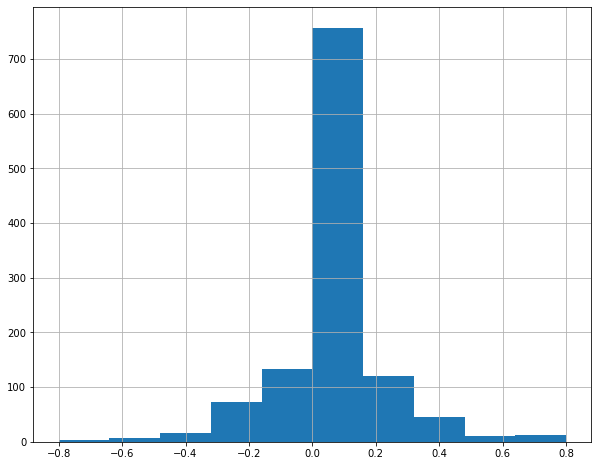

In [23]:
def polarity(text):
    return TextBlob(" ".join(text)).sentiment.polarity

sentences = pd.DataFrame(columns=["sentences", "polarity_score"])

for sent in dataset:
    sentences = sentences.append({'sentences':sent, 'polarity_score':polarity(sent)}, ignore_index=True)
    
sentences['polarity_score'].hist(figsize=(10,8))

In [24]:
# Displaying the sentences that had a polarity score of over .5
sentences[sentences['polarity_score']>.5]

,sentences,polarity_score
88,"[believe, design, win, industry, leader, provi...",0.800000
117,"[design, win, turn, influence, retail, system,...",0.800000
156,"[cannot, accurately, predict, compete, success...",0.575000
170,"[none, employee, covered, collective, bargaini...",0.700000
387,"[income, benefit, derived, difference, exercis...",0.700000
501,"[addition, successfully, develop, introduce, p...",0.625000
510,"[addition, cannot, guarantee, product, develop...",0.750000
543,"[company, industry, experienced, difficulty, m...",0.800000
586,"[sale, addin, board, motherboard, manufacturer...",0.600000
602,"[successful, producing, processor, volume, req...",0.583333


# Similarity Scores

In [25]:
def CosSimilarity(A, B):
    
    # Compile complete set of words in A or B
    words = list(A.union(B))
    
    # Determine which words are in A
    vec_A = [1 if x in A else 0 for x in words]
    
    # Determine which words are in B
    vec_B = [1 if x in B else 0 for x in words]
  
    # Compute cosine score using scikit-learn
    array_A = np.array(vec_A).reshape(1, -1)
    array_B = np.array(vec_B).reshape(1, -1)
    
    cosine_score = cosine_similarity(array_A, array_B)[0,0]
    return cosine_score

In [26]:
def JaccardSimilarity(A, B):
    
    # Count number of words in both A and B
    intersect = len(A.intersection(B))
    
    # Count number of words in A or B
    union = len(A.union(B))
    
    # Compute Jaccard similarity score
    jaccard_score = intersect / union
    
    return jaccard_score

In [27]:
def ComputeSimilarityScores10K(cik):

    # Open the directory that holds text filings for the CIK
    text_dir = os.path.join(cik, 'textonly')
    os.chdir(text_dir)
    print(f"Parsing CIK {cik}...")
    
    # Get list of files to over which to compute scores
    flist = sorted([fname for fname in os.listdir()])
    
    # Check if scores have already been calculated...
    metrics_dir = os.path.join('..', 'metrics')
    os.makedirs(metrics_dir, exist_ok=True)
    
    if os.listdir(metrics_dir):
        print("Similarity Scores are already calculated.")
        os.chdir('../..')
        return
    
    # Check if enough files exist to compute similarity scores
    if len(flist) < 2:
        print(f"No files to compare for CIK {cik}.")
        os.chdir('../..')
        return
    
    # Initialize dataframe to store similarity scores
    # Find the dates from the names of the files that are present in the "textonly directory"
    dates = [x[-14:-4] for x in flist]
    
    # Creating an empty array according to match the size of the cosine score    
    data = pd.DataFrame(index=dates, columns=['cosine_score', 'jaccard_score'])
        
    # Open first file
    file_A = flist[0]
    
    with open(file_A, 'r', encoding='utf-8') as file:
        text_A = file.read()
        
    # Iterate over each 10-K file...
    for i in range(1, len(flist)):
        file_B = flist[i]

        # Get file text B
        with open(file_B, 'r', encoding='utf-8') as file:
            text_B = file.read()

        # Get set of words in A, B
        words_A = set(re.findall(r"[\w']+", text_A))
        words_B = set(re.findall(r"[\w']+", text_B))

        # Calculate similarity scores
        cos_score = CosSimilarity(words_A, words_B)
        jaccard_score = JaccardSimilarity(words_A, words_B)

        # Store score values
        date_B = file_B[-14:-4]
        data.at[date_B, 'cosine_score'] = cos_score
        data.at[date_B, 'jaccard_score'] = jaccard_score

        # Reset value for next loop
        text_A = text_B

    # Save scores to CSV
    os.chdir(metrics_dir)
    data.to_csv(f'{cik}_sim_scores.csv', index=True)
    os.chdir('../..')
    print("Metrics Successfully Calculated, Check Metrics Directory")

In [28]:
os.chdir(path_10k)

for cik in tqdm(tick_cik_df['cik']):
    ComputeSimilarityScores10K(cik)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]

Parsing CIK 0001045810...
Similarity Scores are already calculated.


In [35]:
# Constructing the similarity index dataframe
cik = tick_cik_df['cik'][0]
sim_df = pd.read_csv(path_10k+"/"+cik+"/metrics/"+cik+"_sim_scores.csv")

new_columns = sim_df.columns.values
new_columns[0] = 'Dates'
sim_df.columns = new_columns
sim_df = sim_df.set_index('Dates')

sim_df = sim_df.fillna(0)
sim_df['cosine_score'] = sim_df['cosine_score'].astype(float)
sim_df['jaccard_score'] = sim_df['jaccard_score'].astype(float)

sim_df = pd.concat([sim_df, sim_df.pct_change()] , axis = 1, sort=False)
sim_df

,cosine_score,jaccard_score,cosine_score,jaccard_score
Dates,,,,
2002-05-14,0.000000,0.000000,NaN,NaN
2003-04-25,0.855314,0.747108,inf,inf
2004-03-29,0.855302,0.746827,-0.000014,-0.000376
2005-03-22,0.854843,0.746045,-0.000536,-0.001047
2006-03-16,0.860961,0.755014,0.007157,0.012022
2007-03-16,0.868600,0.766863,0.008872,0.015694
2008-03-21,0.875412,0.778399,0.007842,0.015043
2009-03-13,0.887341,0.796241,0.013627,0.022922
2010-03-18,0.901523,0.820701,0.015982,0.030720


# Stock Prices

In [36]:
ticker = tick_cik_df['ticker'][0]
start_date = datetime(2002, 5, 31)
end_date = datetime(2024, 2, 29)
api_key = 'UGBIPKZSN5NWM5LV'
time_series = web.DataReader(ticker, "av-monthly-adjusted", start=start_date, end=end_date, api_key=api_key)

# Reset index to have the date as a column
time_series.reset_index(inplace=True)

# Ensure the 'date' column is datetime
time_series['index'] = pd.to_datetime(time_series['index'])

# Convert 'Dates' column in your similarity dataframe to datetime for alignment
sim_df.index = pd.to_datetime(sim_df.index)

# Initialize a DataFrame to hold aligned prices
aligned_prices = pd.DataFrame(columns=['Dates', 'Adj Close'])
aligned_prices['Dates'] = sim_df.index

for date in aligned_prices['Dates']:
    # Find the closest available price date in `time_series`
    closest_date = time_series.iloc[(time_series['index'] - date).abs().argsort()[:1]].index[0]
    aligned_prices.loc[aligned_prices['Dates'] == date, 'Adj Close'] = time_series.loc[closest_date, 'adjusted close']
    
aligned_prices.set_index('Dates', inplace=True)

# Strategy

In [37]:
sim_df.columns = ['cosine_score', 'jaccard_score', 'cosine_pct', 'jaccard_pct']

In [39]:
sim_df['Signal'] = ""

# Define thresholds (buy when changes are minimal and sell when changes are unexpected)
COSINE_BUY_THRESHOLD = -0.01
COSINE_SELL_THRESHOLD = +0.02
JACCARD_BUY_THRESHOLD = -0.02
JACCARD_SELL_THRESHOLD = 0.05

# Create a function to determine the trading signal based on similarity changes
def determine_signal(row):
    if row['cosine_pct'] > COSINE_BUY_THRESHOLD or row['jaccard_pct'] > JACCARD_BUY_THRESHOLD:
        return 'Buy'
    elif row['cosine_pct'] < COSINE_SELL_THRESHOLD or row['jaccard_pct'] < JACCARD_SELL_THRESHOLD:
        return 'Sell'
    else:
        return 'Hold'

# Apply the function to each row in the DataFrame to create a new column for signals
sim_df['Signal'] = sim_df.apply(determine_signal, axis=1)
sim_df['Adj Close'] = aligned_prices['Adj Close']
sim_df = sim_df.iloc[2:,:]
sim_df

,cosine_score,jaccard_score,cosine_pct,jaccard_pct,Signal,Adj Close
Dates,,,,,,
2006-03-16,0.860961,0.755014,0.007157,0.012022,Buy,0.4377
2007-03-16,0.868600,0.766863,0.008872,0.015694,Buy,0.44
2008-03-21,0.875412,0.778399,0.007842,0.015043,Buy,0.4538
2009-03-13,0.887341,0.796241,0.013627,0.022922,Buy,0.1899
2010-03-18,0.901523,0.820701,0.015982,0.030720,Buy,0.399
2011-03-16,0.892767,0.805851,-0.009712,-0.018095,Buy,0.4233
2012-03-13,0.829013,0.707782,-0.071412,-0.121696,Sell,0.3474
2013-03-12,0.884217,0.792460,0.066590,0.119638,Buy,0.294
2014-03-13,0.882344,0.789071,-0.002119,-0.004276,Buy,0.4355


# Strategy Returns

In [44]:
initial_cash = 10000
investment_value = initial_cash
signal = None  # To track last action ('Buy', 'Sell')

holding = 0
start, end = None, None

# Iterate over the DataFrame
for i in range(len(sim_df) - 1):
    current_price = sim_df['Adj Close'].iloc[i]
    next_price = sim_df['Adj Close'].iloc[i + 1]
    
    if sim_df['Signal'].iloc[i] == 'Buy':
        investment_value *= (next_price / current_price)
        
        if start is None:
            start = sim_df.index[i]
    
    elif sim_df['Signal'].iloc[i] == 'Sell':
        end = sim_df.index[i]
        holding += (end - start).days
        start = None

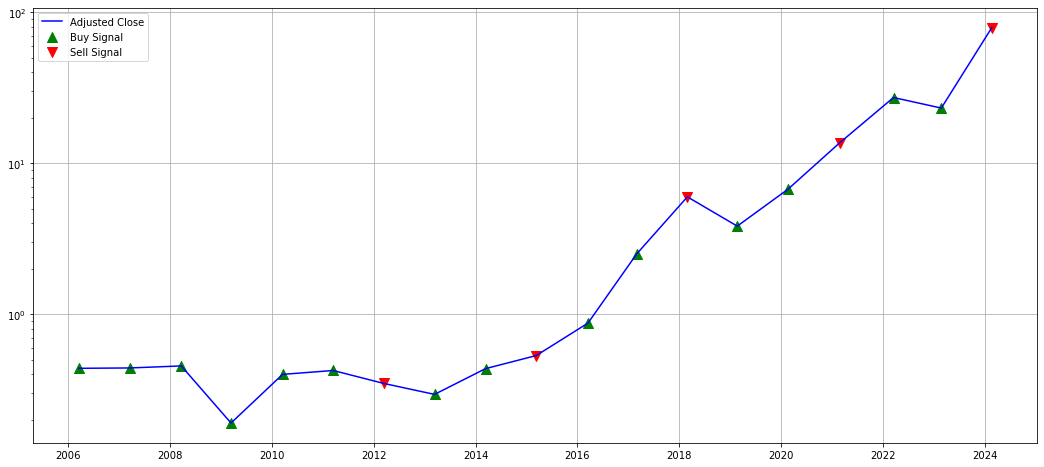

Annual return: 47.20%
Annual return B&H: 33.58%


In [46]:
plt.figure(figsize=(18, 8))
plt.plot(sim_df.index, sim_df['Adj Close'], label='Adjusted Close', color='blue')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Plot Buy signals
buy_signals = sim_df[sim_df['Signal'] == 'Buy']
plt.scatter(buy_signals.index, buy_signals['Adj Close'], marker='^', color='green', label='Buy Signal', s=100)

# Plot Sell signals
sell_signals = sim_df[sim_df['Signal'] == 'Sell']
plt.scatter(sell_signals.index, sell_signals['Adj Close'], marker='v', color='red', label='Sell Signal', s=100)

plt.grid(True)
plt.legend()
plt.show()

###########################################################################################################################################################

initial_cash_BH = 10000
investment_value_BH = sim_df['Adj Close'][-1] / sim_df['Adj Close'][0] * initial_cash

# Calculate annualized returns
ann_return = investment_value / initial_cash
ann_return = (ann_return ** (1 / (holding/365)) - 1) * 100

ann_return_BH = investment_value_BH / initial_cash_BH
holding_BH = (sim_df.index[-1] - sim_df.index[0]).days
ann_return_BH = (ann_return_BH ** (1 / (holding_BH/365)) - 1) * 100

print(f"Annual return: {ann_return:.2f}%")
print(f"Annual return B&H: {ann_return_BH:.2f}%")